In [56]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import re
import string
from string import punctuation
import nltk
from nltk.corpus import stopwords

from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN
from textblob import download_corpora
import textblob
from textblob import TextBlob

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
# Set environment variables for single-threaded execution
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["OMP_NUM_THREADS"] = "1"

In [3]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\35383\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
# from google.colab import files

# # Upload the file
# uploaded = files.upload()

# # Get the filename
# filename = list(uploaded.keys())[0]

# # Read the CSV file into a DataFrame
# data = pd.read_csv(filename)


In [5]:
file_path = 'reviews.csv'
data = pd.read_csv(file_path)


In [6]:
data.head()

,Review date,Guest name,Reservation Number,Review title,Positive review,Negative review,Review score,Staff,Cleanliness,Location,Facilities,Comfort,Value for money,Property reply
0,2021-05-26 13:52:54,Sarah,2.916039e+09,Great stay,"Lovely staff, lovely clean hotel, great food",NaN,10.0,10.0,10.0,7.5,10.0,10.0,10.0,Thank you for taking the time to share your re...
1,2021-05-26 17:25:42,Diana,3.068738e+09,NaN,Location,NaN,9.0,10.0,7.5,10.0,10.0,10.0,10.0,"Dear Diana,\nThank you for the 9/10 rating.\nI..."
2,2021-05-27 13:25:33,ryane,2.505493e+09,Great hotel with helpful friendly staff.,NaN,NaN,10.0,10.0,10.0,10.0,10.0,10.0,10.0,NaN
3,2021-05-28 09:27:09,lorraine,3.332737e+09,NaN,The room was spotless and the food was fabulous.,NaN,9.0,10.0,7.5,10.0,10.0,10.0,10.0,"Dear Lorraine,\nThanks for the great review of..."
4,2021-05-30 17:15:46,Mike,2.650766e+09,NaN,"Great location, excellent food and friendly st...",NaN,10.0,10.0,10.0,10.0,7.5,10.0,10.0,"Dear Mike, \nThank you for the great review an..."


In [7]:
data = data.drop(['Review date', 'Guest name', 'Reservation Number','Review title','Staff','Cleanliness','Location','Facilities','Comfort','Value for money','Property reply' ], axis=1)
data.dropna(inplace=True)

In [8]:
# Combine the 'Positive review' and 'Negative review' columns into a single 'Review' column
data['Review'] = data['Positive review'].fillna('') + ' ' + data['Negative review'].fillna('')

In [9]:
# Adapt the sentiment classification to the review scores in our dataset
#data['Sentiment'] = data['Review score'].apply(lambda x: 'Positive' if x > 6 else ('Neutral' if x == 5 else 'Negative'))

In [10]:
data.head()

,Positive review,Negative review,Review score,Review
5,Everything was amazing staff room bar staff ð,Everything was great amazing time,10.0,Everything was amazing staff room bar staff ð...
7,Location is great. Room was very clean and com...,Staff trying to come into our room with no rea...,8.0,Location is great. Room was very clean and com...
8,Spotless clean food was great and staff where ...,Nothing got what you paid for couldn’t fault it,10.0,Spotless clean food was great and staff where ...
9,I really loved the room it was lovely and clean,I liked everything!!,10.0,I really loved the room it was lovely and clea...
10,"Convenient location, clean and tidy with excel...",A little run down looking from the outside. Co...,8.0,"Convenient location, clean and tidy with excel..."


## Applying Textblob

In [11]:
def get_sentiment(text):
    analysis = TextBlob(text)
    if analysis.sentiment.polarity > 0:
        return 'Positive'
    elif analysis.sentiment.polarity == 0:
        return 'Neutral'
    else:
        return 'Negative'



In [12]:
# Apply sentiment analysis to both columns
data['Review Sentiment'] = data['Review'].apply(get_sentiment)


In [13]:
data.head()

,Positive review,Negative review,Review score,Review,Review Sentiment
5,Everything was amazing staff room bar staff ð,Everything was great amazing time,10.0,Everything was amazing staff room bar staff ð...,Positive
7,Location is great. Room was very clean and com...,Staff trying to come into our room with no rea...,8.0,Location is great. Room was very clean and com...,Positive
8,Spotless clean food was great and staff where ...,Nothing got what you paid for couldn’t fault it,10.0,Spotless clean food was great and staff where ...,Positive
9,I really loved the room it was lovely and clean,I liked everything!!,10.0,I really loved the room it was lovely and clea...,Positive
10,"Convenient location, clean and tidy with excel...",A little run down looking from the outside. Co...,8.0,"Convenient location, clean and tidy with excel...",Positive


In [14]:
data['Review Sentiment'].value_counts()

Review Sentiment
Positive    1113
Neutral      286
Negative     112
Name: count, dtype: int64

C:\Users\35383\AppData\Local\Temp\ipykernel_32940\888952294.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Review score',data=data, palette='YlGnBu_r')


<Axes: xlabel='Review score', ylabel='count'>

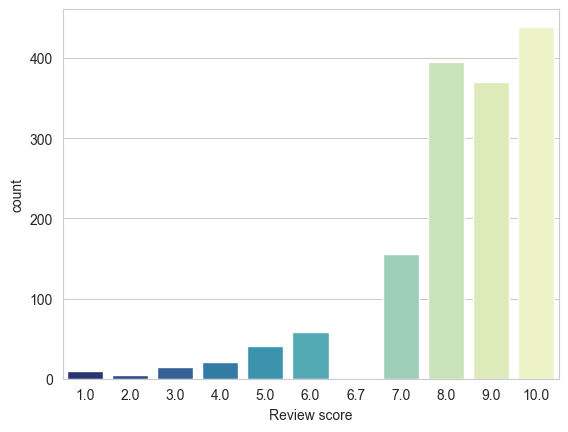

In [15]:
sns.set_style('whitegrid')
sns.countplot(x='Review score',data=data, palette='YlGnBu_r')

C:\Users\35383\AppData\Local\Temp\ipykernel_32940\4280014457.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Review Sentiment',data=data, palette='summer')


<Axes: xlabel='Review Sentiment', ylabel='count'>

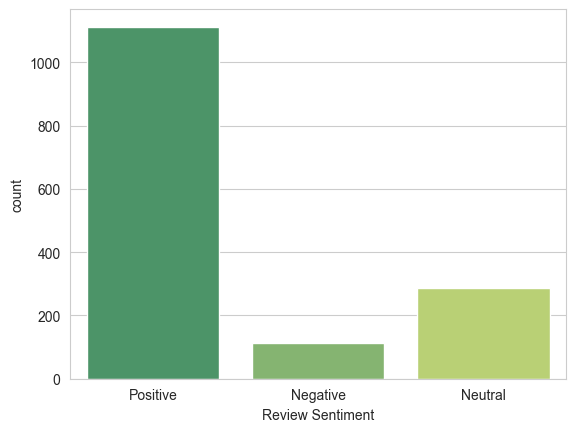

In [16]:
sns.set_style('whitegrid')
sns.countplot(x='Review Sentiment',data=data, palette='summer')

Data Processing

In [17]:
# df_Positive = data[data['Review Sentiment'] == 'Positive'][0:1113]
# df_Neutral = data[data['Review Sentiment'] == 'Neutral']
# df_Negative = data[data['Review Sentiment'] == 'Negative']

In [18]:
# df_Neutral_over = df_Neutral.sample(1113, replace=True)
# df_Negative_over = df_Negative.sample(1113, replace=True)
# data = pd.concat([df_Positive, df_Neutral_over, df_Negative_over], axis=0)

In [19]:
# def get_text_processing(text):
#     stpword = stopwords.words('english')
#     no_punctuation = [char for char in text if char not in string.punctuation]
#     no_punctuation = ''.join(no_punctuation)
#     return ' '.join([word for word in no_punctuation.split() if word.lower() not in stpword])

In [20]:
def get_text_processing(text):
    # Remove unwanted characters and keep only letters and numbers
    text = re.sub(r'[^A-Za-z0-9\s]', '', text)
    
    # Convert to lowercase
    text = text.lower()
    
    # Tokenize and remove stopwords
    stpword = stopwords.words('english')
    words = text.split()
    return ' '.join([word for word in words if word not in stpword])

In [21]:
data['review'] = data['Review'].apply(get_text_processing)

In [22]:
data.head()

,Positive review,Negative review,Review score,Review,Review Sentiment,review
5,Everything was amazing staff room bar staff ð,Everything was great amazing time,10.0,Everything was amazing staff room bar staff ð...,Positive,everything amazing staff room bar staff everyt...
7,Location is great. Room was very clean and com...,Staff trying to come into our room with no rea...,8.0,Location is great. Room was very clean and com...,Positive,location great room clean comfortable short st...
8,Spotless clean food was great and staff where ...,Nothing got what you paid for couldn’t fault it,10.0,Spotless clean food was great and staff where ...,Positive,spotless clean food great staff welcoming help...
9,I really loved the room it was lovely and clean,I liked everything!!,10.0,I really loved the room it was lovely and clea...,Positive,really loved room lovely clean liked everything
10,"Convenient location, clean and tidy with excel...",A little run down looking from the outside. Co...,8.0,"Convenient location, clean and tidy with excel...",Positive,convenient location clean tidy excellent staff...


In [23]:
data_model = data[['review', 'Review Sentiment']]

In [24]:
data_model.head()

,review,Review Sentiment
5,everything amazing staff room bar staff everyt...,Positive
7,location great room clean comfortable short st...,Positive
8,spotless clean food great staff welcoming help...,Positive
9,really loved room lovely clean liked everything,Positive
10,convenient location clean tidy excellent staff...,Positive


In [25]:
data_model.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1511 entries, 5 to 5284
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   review            1511 non-null   object
 1   Review Sentiment  1511 non-null   object
dtypes: object(2)
memory usage: 35.4+ KB


In [26]:
one_hot = pd.get_dummies(data_model["Review Sentiment"])
data_model.drop(['Review Sentiment'],axis=1,inplace=True)
data_model = pd.concat([data_model,one_hot],axis=1)
data_model.head()

C:\Users\35383\AppData\Local\Temp\ipykernel_32940\2024612391.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_model.drop(['Review Sentiment'],axis=1,inplace=True)


,review,Negative,Neutral,Positive
5,everything amazing staff room bar staff everyt...,False,False,True
7,location great room clean comfortable short st...,False,False,True
8,spotless clean food great staff welcoming help...,False,False,True
9,really loved room lovely clean liked everything,False,False,True
10,convenient location clean tidy excellent staff...,False,False,True


In [27]:
X = data_model['review'].values
y = data_model.drop('review', axis=1).values


In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [29]:
vect = CountVectorizer()
X_train = vect.fit_transform(X_train)
X_test = vect.transform(X_test)

In [30]:
tfidf = TfidfTransformer()
X_train = tfidf.fit_transform(X_train)
X_test = tfidf.transform(X_test)
#X_train = X_train.toarray()
#X_test = X_test.toarray()


In [31]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

In [32]:
# Combine the resampled data into a DataFrame (Note: X_resampled needs to be converted to a dense format)
data_balanced = pd.DataFrame(X_resampled.toarray(), columns=vect.get_feature_names_out())
data_balanced = pd.concat([data_balanced, pd.DataFrame(y_resampled, columns=one_hot.columns)], axis=1)

In [40]:
y_resampled.shape

(2673, 3)

In [44]:
model = Sequential()

model.add(Dense(units=1500,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(units=700,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(units=350,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(units=3, activation='softmax'))

opt=tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)

In [45]:
# Train the model with a different batch size and more epochs
history = model.fit(X_resampled, y_resampled, validation_data=(X_test, y_test), epochs=10, batch_size=64, verbose=1, callbacks=[early_stop])

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")


Epoch 1/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 9s 109ms/step - accuracy: 0.5754 - loss: 0.8833 - val_accuracy: 0.8581 - val_loss: 0.6025
Epoch 2/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 84ms/step - accuracy: 0.9842 - loss: 0.0549 - val_accuracy: 0.8152 - val_loss: 1.0604
Epoch 3/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 87ms/step - accuracy: 0.9996 - loss: 0.0055 - val_accuracy: 0.8647 - val_loss: 0.8588
Epoch 3: early stopping
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8490 - loss: 0.9093 
Test Loss: 0.8587927222251892
Test Accuracy: 0.8646864891052246


In [54]:
# Predict the labels for the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


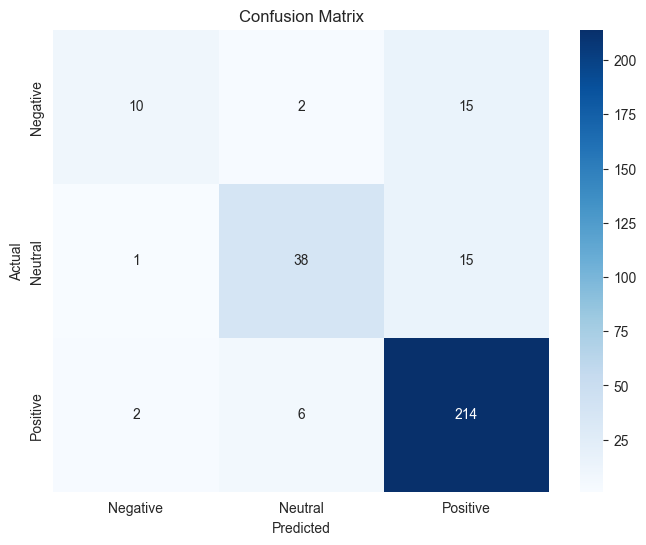

              precision    recall  f1-score   support

    Negative       0.77      0.37      0.50        27
     Neutral       0.83      0.70      0.76        54
    Positive       0.88      0.96      0.92       222

    accuracy                           0.86       303
   macro avg       0.82      0.68      0.73       303
weighted avg       0.86      0.86      0.85       303



In [57]:
# Generate the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=one_hot.columns, yticklabels=one_hot.columns)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print(classification_report(y_true, y_pred_classes, target_names=one_hot.columns))